## Hidden Markov Model
### Training the parameter based on the chorales dataset
The chorales dataset contains the chords, each corresponding with the measures. The idea is that we apply Baum-Welch algorithm on the dataset to train the parameters of the HMM model. For simplification, we have 24 states corresponding to 24 Maj Min chords (could be extended to sus4 and dim).

Bigram counting is used to record the transition of chords.

##  Bigram counting

In [166]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import scipy
import librosa
import soundfile as sf
import IPython.display as ipd
import pandas as pd
import os
from sklearn.preprocessing import normalize 

import libfmp.b
import libfmp.c3
import libfmp.c4


In [167]:
# Load chord label function
def load_chord_labels(file_path):
    # Load the chord labels
    chord_labels = pd.read_csv(file_path, sep=',')
    chord_labels.columns = ['start_meas', 'end_meas', 'chord']
    # Simplify the chord labels to <root>:<quality[:2]>
    chord_labels['chord'] = chord_labels['chord'].apply(lambda x: x.split(':'))
    
    return chord_labels

In [168]:
# Load dataset
file_path = 'dataset/Anonymous_AusMeinesHerzensGrunde.csv'

# Load the chord labels
chord_labels = load_chord_labels(file_path)
print(chord_labels['chord'])

# Simplify the chord labels to [<root> <maj/min>]
# <sus>, <maj> -> <maj>
# <dim>, <min> -> <min>
# all others -> <maj>
def simplify_chords(chord):
    if chord[1] == 'maj' or chord[1] == 'sus':
        return chord[0] + 'maj'
    elif chord[1] == 'dim' or chord[1] == 'min':
        return chord[0] + 'min'
    else:
        return chord[0] + 'maj'

chord_labels['chord'] = chord_labels['chord'].apply(lambda x : simplify_chords(x))
print(chord_labels['chord'])

0               [G, maj]
1               [E, min]
2             [D, maj/3]
3               [G, maj]
4             [G, maj/3]
5               [D, maj]
6               [E, min]
7               [D, maj]
8               [G, maj]
9             [D, maj/3]
10              [G, maj]
11             [D, sus4]
12              [D, maj]
13          [G, maj(*5)]
14              [G, maj]
15              [E, min]
16            [D, maj/3]
17              [G, maj]
18            [G, maj/3]
19              [D, maj]
20              [E, min]
21              [D, maj]
22              [G, maj]
23            [D, maj/3]
24              [G, maj]
25             [D, sus4]
26              [D, maj]
27          [G, maj(*5)]
28              [G, maj]
29              [E, min]
30            [D, maj/3]
31              [G, maj]
32              [D, maj]
33              [E, min]
34            [B, min/3]
35            [A, min/3]
36              [B, min]
37            [G, maj/3]
38            [D, maj/3]
39              [G, maj]


In [169]:
# Bigram counting
# Create an array listing chord progression according to the chord labels
array_chords = chord_labels['chord'].to_numpy()
print(array_chords)

def bigram_counting(array):
    # Create a dictionary to store the bigram counts
    bigram_counts = {}
    
    # Loop through the array to count the bigrams
    for i in range(len(array) - 1):
        bigram = (array[i], array[i+1])
        if bigram in bigram_counts:
            bigram_counts[bigram] += 1
        else:
            bigram_counts[bigram] = 1
            
    return bigram_counts

# Count the bigrams
bigram_counts = bigram_counting(array_chords)
print(bigram_counts)

['Gmaj' 'Emin' 'Dmaj' 'Gmaj' 'Gmaj' 'Dmaj' 'Emin' 'Dmaj' 'Gmaj' 'Dmaj'
 'Gmaj' 'Dmaj' 'Dmaj' 'Gmaj' 'Gmaj' 'Emin' 'Dmaj' 'Gmaj' 'Gmaj' 'Dmaj'
 'Emin' 'Dmaj' 'Gmaj' 'Dmaj' 'Gmaj' 'Dmaj' 'Dmaj' 'Gmaj' 'Gmaj' 'Emin'
 'Dmaj' 'Gmaj' 'Dmaj' 'Emin' 'Bmaj' 'Amaj' 'Bmin' 'Gmaj' 'Dmaj' 'Gmaj'
 'Gmaj' 'Dmaj' 'Amin' 'Dmaj' 'Gmaj' 'Dmaj' 'Emin' 'Bmaj' 'Emin' 'Dmaj'
 'Gmaj' 'Bmin' 'Gmaj' 'Dmaj' 'Dmaj' 'Gmaj']
{('Gmaj', 'Emin'): 3, ('Emin', 'Dmaj'): 6, ('Dmaj', 'Gmaj'): 13, ('Gmaj', 'Gmaj'): 5, ('Gmaj', 'Dmaj'): 11, ('Dmaj', 'Emin'): 4, ('Dmaj', 'Dmaj'): 3, ('Emin', 'Bmaj'): 2, ('Bmaj', 'Amaj'): 1, ('Amaj', 'Bmin'): 1, ('Bmin', 'Gmaj'): 2, ('Dmaj', 'Amin'): 1, ('Amin', 'Dmaj'): 1, ('Bmaj', 'Emin'): 1, ('Gmaj', 'Bmin'): 1}


In [170]:
# Counting bigram for all of the .csv
# For each dataset, load the chord labels, simplify the chord labels, and count the bigrams
# Create a dictionary to store the bigram counts
bigram_counts = {}
uniquie_chords = set()

# Loop through the dataset
for file in os.listdir('dataset'):
    # Load the chord labels
    chord_labels = load_chord_labels('dataset/' + file)
    
    # Simplify the chord labels
    chord_labels['chord'] = chord_labels['chord'].apply(lambda x : simplify_chords(x))
    
    # Update the set of unique chords
    uniquie_chords.update(chord_labels['chord'])
    
    # Create an array listing chord progression according to the chord labels
    array_chords = chord_labels['chord'].to_numpy()
    
    # Count the bigrams
    bigram_counts[file] = bigram_counting(array_chords)

print(bigram_counts)

# Combine the bigram counts across all datasets
bigram_counts_all = {}
for bigram_count in bigram_counts.values():
    for bigram, count in bigram_count.items():
        if bigram in bigram_counts_all:
            bigram_counts_all[bigram] += count
        else:
            bigram_counts_all[bigram] = count

print(bigram_counts_all)
print(uniquie_chords)

{'Anonymous_AusMeinesHerzensGrunde.csv': {('Gmaj', 'Emin'): 3, ('Emin', 'Dmaj'): 6, ('Dmaj', 'Gmaj'): 13, ('Gmaj', 'Gmaj'): 5, ('Gmaj', 'Dmaj'): 11, ('Dmaj', 'Emin'): 4, ('Dmaj', 'Dmaj'): 3, ('Emin', 'Bmaj'): 2, ('Bmaj', 'Amaj'): 1, ('Amaj', 'Bmin'): 1, ('Bmin', 'Gmaj'): 2, ('Dmaj', 'Amin'): 1, ('Amin', 'Dmaj'): 1, ('Bmaj', 'Emin'): 1, ('Gmaj', 'Bmin'): 1}, 'Bach_IchStehAnDeinerKrippe.csv': {('Bmin', 'Bmaj'): 2, ('Bmaj', 'F#maj'): 2, ('F#maj', 'Bmin'): 3, ('Bmin', 'Gmaj'): 2, ('Gmaj', 'Amaj'): 6, ('Amaj', 'Amaj'): 2, ('Amaj', 'Dmaj'): 6, ('Dmaj', 'F#min'): 3, ('F#min', 'Gmaj'): 2, ('Dmaj', 'Emaj'): 2, ('Emaj', 'F#maj'): 3, ('F#maj', 'F#maj'): 2, ('F#maj', 'F#min'): 1, ('F#min', 'Dmaj'): 1, ('Dmaj', 'Gmaj'): 3, ('Gmaj', 'Dmaj'): 1, ('Dmaj', 'Amaj'): 1, ('Amaj', 'Bmin'): 1, ('Bmin', 'Dmaj'): 1, ('Amaj', 'Emin'): 1, ('Emin', 'Amaj'): 1, ('F#min', 'Emaj'): 1, ('F#maj', 'Bmaj'): 2, ('Bmaj', 'Emin'): 1, ('Emin', 'F#maj'): 1}, 'Crueger_AufAufMeinHerzMitFreuden.csv': {('Cmaj', 'Cmaj'): 3, ('Cm

['Amaj' 'Bmin' 'Dmaj' 'Emaj' 'Emin' 'F#maj' 'F#min' 'Gmaj']


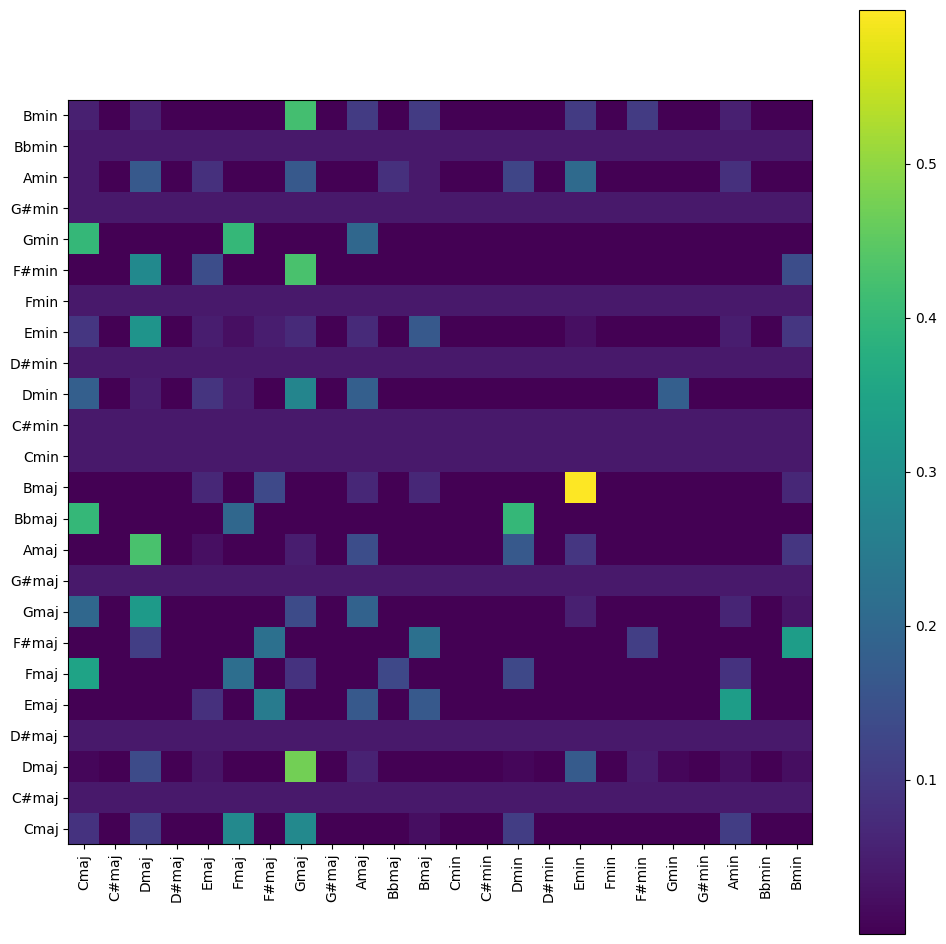

In [171]:
# Baum-Welch algorithm
# Create a list of unique chords
unique_chords = np.unique(array_chords)
print(unique_chords)

# Codebook that maps each chord to an index
chord_24 = ['Cmaj', 'C#maj', 'Dmaj', 'D#maj', 'Emaj', 'Fmaj', 'F#maj', 'Gmaj', 'G#maj', 'Amaj', 'Bbmaj', 'Bmaj', 'Cmin', 'C#min', 'Dmin', 'D#min', 'Emin', 'Fmin', 'F#min', 'Gmin', 'G#min', 'Amin', 'Bbmin', 'Bmin']

codebook = {chord: i for i, chord in enumerate(chord_24)}

# Create a transition matrix
# Initialize the transition matrix with epsilon to avoid zero probabilities
A = np.ones((24, 24)) * 1e-6

# Loop through the bigram_counts_all to populate the transition matrix
for bigram, count in bigram_counts_all.items():
    i = codebook[bigram[0]]
    j = codebook[bigram[1]]
    A[i, j] = count

# Normalize the transition matrix
A = A / np.sum(A, axis=1)[:, np.newaxis]

# Plot the transition matrix
plt.figure(figsize=(12, 12))
plt.imshow(A, origin='lower')
plt.colorbar()
plt.xticks(np.arange(24), chord_24, rotation=90)
plt.yticks(np.arange(24), chord_24)
plt.show()

In [177]:
def generate_sequence_hmm(N, A, C, B, details=False):
    """Generate observation and state sequence from given HMM

    Notebook: C5/C5S3_HiddenMarkovModel.ipynb

    Args:
        N (int): Number of observations to be generated
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution of dimension I
        B (np.ndarray): Output probability matrix of dimension I x K
        details (bool): If "True" then shows details (Default value = False)

    Returns:
        O (np.ndarray): Observation sequence of length N
        S (np.ndarray): State sequence of length N
    """
    assert N > 0, "N should be at least one"
    I = A.shape[1]
    K = B.shape[1]
    assert I == A.shape[0], "A should be an I-square matrix"
    assert I == C.shape[0], "Dimension of C should be I"
    assert I == B.shape[0], "Column-dimension of B should be I"

    O = np.zeros(N, int)
    S = np.zeros(N, int)
    for n in range(N):
        if n == 0:
            i = np.random.choice(np.arange(I), p=C)
        else:
            i = np.random.choice(np.arange(I), p=A[i, :])
        k = np.random.choice(np.arange(K), p=B[i, :])
        S[n] = i
        O[n] = k
        if details:
            print('n = %d, S[%d] = %d, O[%d] = %d' % (n, n, S[n], n, O[n]))
    return O, S


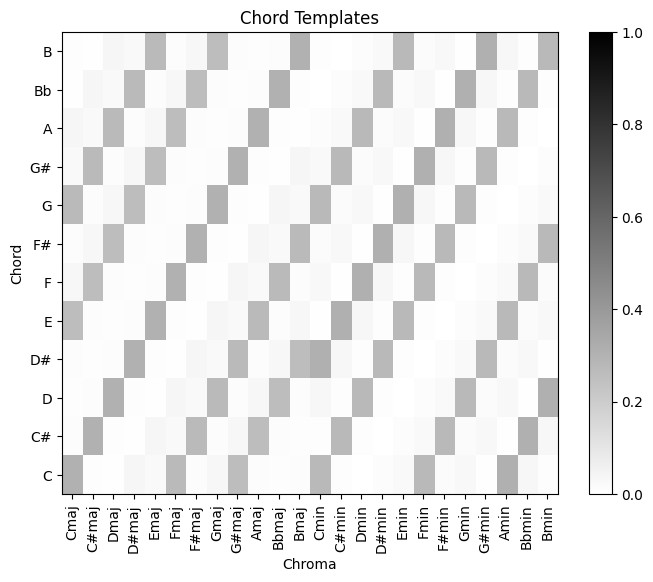

In [175]:
def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_templates (np.ndarray): Matrix containing chord_templates as columns
    """
    # Assuming the Gaussian distribution of chroma features at the triad positions + AWGN
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmaj = template_cmaj + 1e-1 * np.abs(np.random.randn(12))
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = template_cmin + 1e-1 * np.abs(np.random.randn(12))

    template_cmaj = template_cmaj / np.sum(template_cmaj)
    template_cmin = template_cmin / np.sum(template_cmin)
    
    if nonchord:
        num_chord = 25
    else:
        num_chord = 24
    chord_templates = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates[:, shift] = np.roll(template_cmaj, shift)
        chord_templates[:, shift+12] = np.roll(template_cmin, shift)
    return chord_templates

# Generate chord templates
chord_templates = generate_chord_templates()
# Plot chord templates
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
libfmp.b.plot_matrix(chord_templates, ax=[ax], xlabel='Chroma', ylabel='Chord', title='Chord Templates', clim=[0, 1])
plt.yticks(np.arange(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B'])
plt.xticks(np.arange(24), chord_24, rotation=90)
plt.show()

In [176]:
# Generate observation sequence
N = 10
C = np.ones(24) / 24
B = generate_chord_templates().T
print(B.shape)
print(A.shape)
O, S = generate_sequence_hmm(N, A, C, B)


(24, 12)
(24, 24)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
